
Class distribution in Training set:
Class 0: 2832 samples
Class 1: 7354 samples

Class distribution in Test set:
Class 0: 1214 samples
Class 1: 3152 samples

✔️ Class distribution between Train and Test sets is similar.
Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - accuracy: 0.7273 - loss: 0.5513 - val_accuracy: 0.7293 - val_loss: 0.5131 - learning_rate: 5.0000e-04
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7914 - loss: 0.4398 - val_accuracy: 0.7320 - val_loss: 0.4982 - learning_rate: 5.0000e-04
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8087 - loss: 0.4180 - val_accuracy: 0.7950 - val_loss: 0.4094 - learning_rate: 5.0000e-04
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8240 - loss: 0.3884 - val_accuracy: 0.8223 - val_loss: 0.3885 - learning_rate: 5.0000e-04
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8295 - loss: 0.3843 - val_accuracy: 0.8000 - val_loss: 0.4050 - learning_rate: 5.0

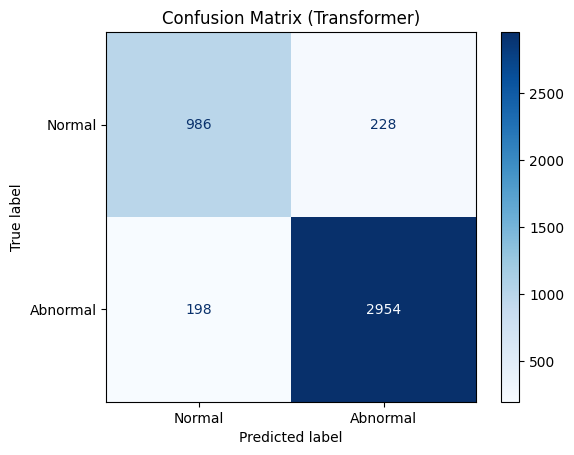

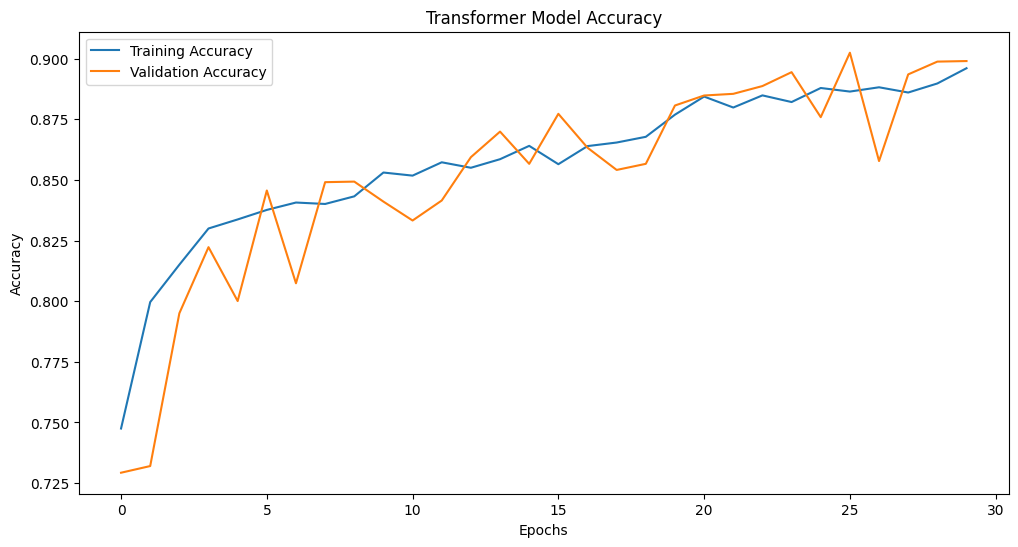

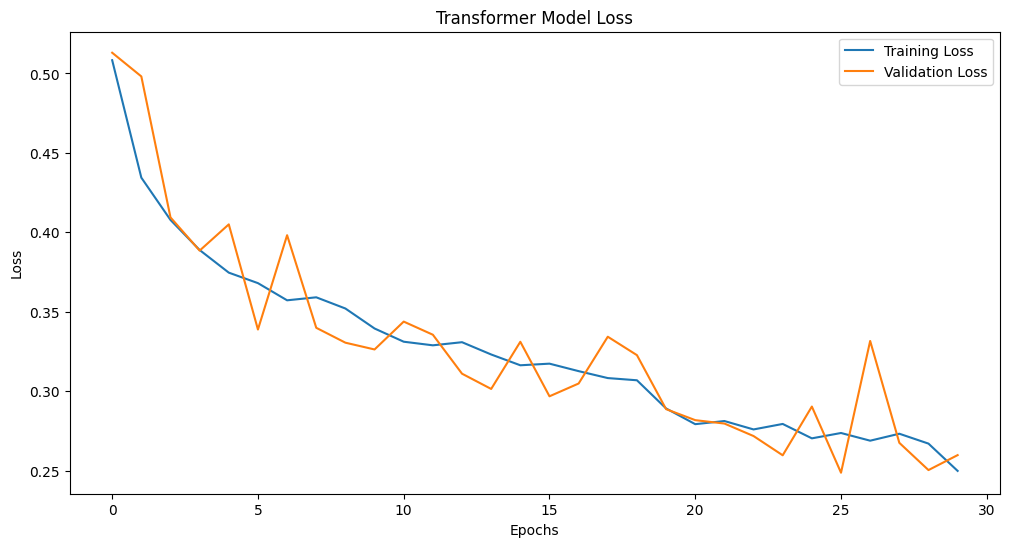

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to check data split
def check_data_split(X_train, X_test, y_train, y_test):
    intersection = np.intersect1d(X_train.flatten(), X_test.flatten())
    if len(intersection) > 0:
        print("Warning: There is overlap between training and test sets!")
    else:
        print("\u2714\ufe0f No overlap between training and test sets.")

    train_classes, train_counts = np.unique(y_train, return_counts=True)
    print("\nClass distribution in Training set:")
    for cls, count in zip(train_classes, train_counts):
        print(f"Class {cls}: {count} samples")

    test_classes, test_counts = np.unique(y_test, return_counts=True)
    print("\nClass distribution in Test set:")
    for cls, count in zip(test_classes, test_counts):
        print(f"Class {cls}: {count} samples")

    train_distribution = train_counts / len(y_train)
    test_distribution = test_counts / len(y_test)
    if np.allclose(train_distribution, test_distribution, atol=0.05):
        print("\n\u2714\ufe0f Class distribution between Train and Test sets is similar.")
    else:
        print("\nWarning: Class distribution between Train and Test sets differs significantly!")

# Load data
normal_data = pd.read_csv('ptbdb_normal.csv', header=None)
abnormal_data = pd.read_csv('ptbdb_abnormal.csv', header=None)

# Remove the last column
normal_data = normal_data.drop(columns=[normal_data.columns[-1]])
abnormal_data = abnormal_data.drop(columns=[abnormal_data.columns[-1]])

# Add labels
normal_data['label'] = 0
abnormal_data['label'] = 1

# Combine data
data = pd.concat([normal_data, abnormal_data], axis=0).reset_index(drop=True)

# Split features and labels
X = data.iloc[:, :-1].values
y = data['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
check_data_split(X_train, X_test, y_train, y_test)

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply Fourier Transform (optional for feature extraction)
def apply_fourier_transform(data):
    return np.abs(np.fft.fft(data, axis=1))

X_train = apply_fourier_transform(X_train)
X_test = apply_fourier_transform(X_test)

# Reshape for Transformer input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define Transformer Encoder Block
def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.1):
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention = tf.keras.layers.Dropout(dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ff = tf.keras.layers.Dense(ff_dim, activation='relu')(attention)
    ff = tf.keras.layers.Dense(inputs.shape[-1])(ff)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + ff)

# Build Transformer-based Model
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = transformer_encoder(x, num_heads=4, ff_dim=128)
x = transformer_encoder(x, num_heads=4, ff_dim=128)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_transformer = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile model
model_transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
history_transformer = model_transformer.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# Evaluate model
loss_transformer, accuracy_transformer = model_transformer.evaluate(X_test, y_test)
print(f'Test Accuracy with Transformer: {accuracy_transformer * 100:.2f}%')

# Predictions and confusion matrix
y_pred_transformer = (model_transformer.predict(X_test) > 0.5).astype(int)
print("\nClassification Report (Transformer):")
print(classification_report(y_test, y_pred_transformer))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_transformer)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Transformer)")
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_transformer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transformer.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Transformer Model Accuracy')
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Transformer Model Loss')
plt.show()
